## Ships dwell time and Linear Regression

One of our project's goals is to predict ship dwell time. Dwell time is a continuous variable and a popular modeling choice for continuous variables is linear regression. In this notebook we experiment with linear regression and will use it as a baseline to compare to other more sophisticated modeling techniques. The data is already cleaned at this point and ready for analysis. We'll read it in from CSV file.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42
%matplotlib inline

In [2]:
df_dwell = pd.read_csv('/work/data/cleansed/vessel_dwell_time.csv')

### Basic EDA

Perform some general EDA to see if there are any obvious relationships.

In [3]:
df_dwell.shape

(1634, 16)

In [4]:
df_dwell.sample(5)

,imo,vessel_name,time_seen,target_terminal,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_operator,vessel_type,vessel_width,vessel_length,vessel_dwt,dwell_in_hr
348,IMO9215878,MAERSK NEWCASTLE,2020-02-11 07:46:04,PierT,23.8,0.0,52.0,1,7,False,MAERSK,Container ship,30.0,210.0,34717.0,54.2
925,IMO9645865,CSCL SUMMER,2021-02-07 14:28:38,PierJ,171.3,2.0,79.0,6,14,False,COSCO SHIPPING LINES,Container ship,48.0,335.0,121805.0,123.5
643,IMO9386988,PETKUM,2021-11-01 23:59:11,PierA,267.6,2.0,157.0,0,23,False,MAERSK,Container ship,25.0,161.0,16975.0,37.5
1535,IMO9785809,COSCO SHIPPING ROSE,2022-06-28 20:08:16,PierE,20.5,2.0,97.0,1,20,False,COSCO SHIPPING LINES,Container ship,48.0,366.0,146714.0,17.9
1135,IMO9334143,NAVIOS AMARANTH,2021-08-31 07:50:40,PierA,93.8,3.0,125.0,1,7,False,MATSON,Container ship,32.0,260.0,50661.0,37.2


In [5]:
df_dwell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imo                               1634 non-null   object 
 1   vessel_name                       1634 non-null   object 
 2   time_seen                         1634 non-null   object 
 3   target_terminal                   1634 non-null   object 
 4   avg_dwell_at_target_terminal      1634 non-null   float64
 5   num_of_vessel_at_target_terminal  1634 non-null   float64
 6   num_of_vessel_in_port             1634 non-null   float64
 7   weekday                           1634 non-null   int64  
 8   hour_of_day                       1634 non-null   int64  
 9   is_holiday                        1634 non-null   bool   
 10  vessel_operator                   1634 non-null   object 
 11  vessel_type                       1634 non-null   object 
 12  vessel

In [6]:
df_dwell.describe()

,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,vessel_width,vessel_length,vessel_dwt,dwell_in_hr
count,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000
mean,90.459608,1.336597,83.168911,3.043452,11.412485,37.727050,286.559364,79195.031212,95.878091
std,121.660452,1.055378,35.435609,2.089239,7.553767,7.993578,56.244615,43579.497345,186.143307
min,1.800000,0.000000,0.000000,0.000000,0.000000,15.000000,105.000000,5771.000000,0.500000
25%,17.225000,0.000000,55.000000,1.000000,5.000000,32.000000,247.000000,39383.000000,12.500000
50%,40.700000,1.000000,84.000000,3.000000,11.000000,32.000000,293.000000,66971.000000,17.500000
75%,109.600000,2.000000,102.000000,5.000000,19.000000,45.000000,334.000000,111861.000000,98.425000
max,1096.100000,4.000000,181.000000,6.000000,23.000000,59.000000,400.000000,200148.000000,1740.400000


Get some visuals see if anything obvious

In [7]:
df = df_dwell.copy()
# df['is_holiday_num'] = df['is_holiday'].astype(int)
# df = df.drop('is_holiday', axis=1)
df.columns

Index(['imo', 'vessel_name', 'time_seen', 'target_terminal',
       'avg_dwell_at_target_terminal', 'num_of_vessel_at_target_terminal',
       'num_of_vessel_in_port', 'weekday', 'hour_of_day', 'is_holiday',
       'vessel_operator', 'vessel_type', 'vessel_width', 'vessel_length',
       'vessel_dwt', 'dwell_in_hr'],
      dtype='object')

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


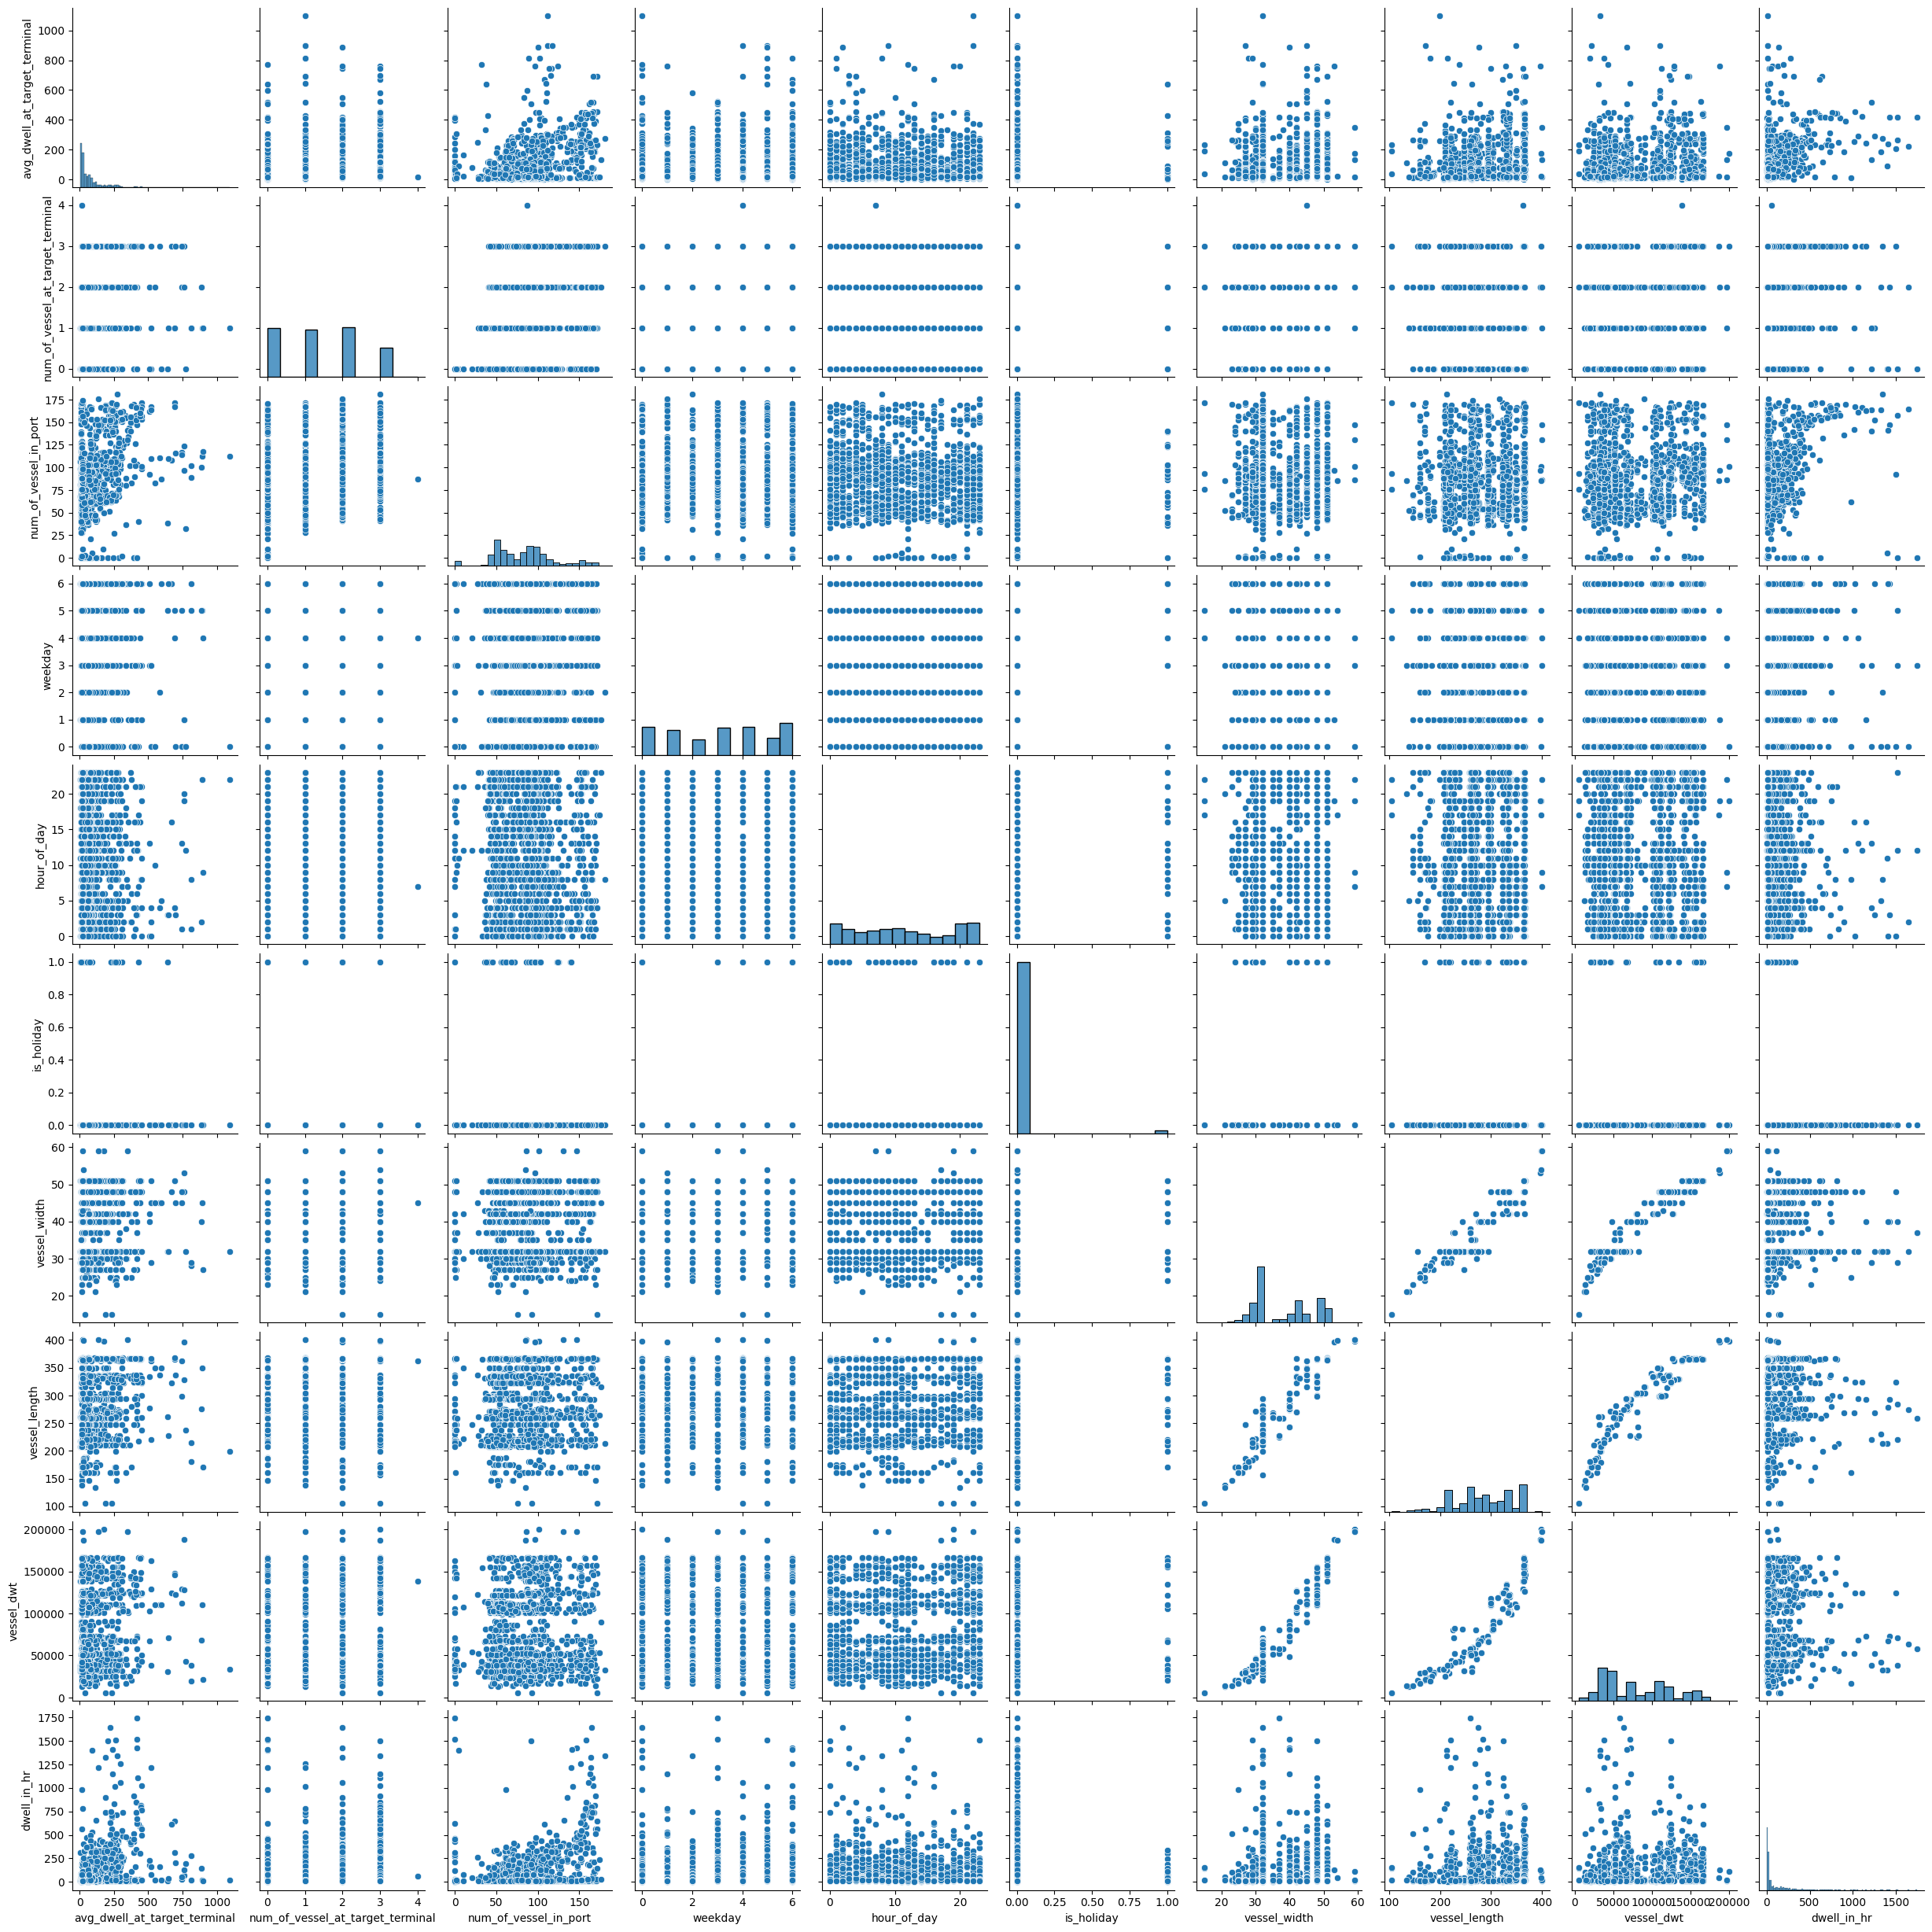

In [8]:
sns.pairplot(df)

The data contains both numeric and categorical data. Without doing one hot encoding yet, let's take a quick look at correlations...

In [9]:
df.corr()

,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_width,vessel_length,vessel_dwt,dwell_in_hr
avg_dwell_at_target_terminal,1.000000,0.257606,0.366017,0.004283,-0.040778,0.059836,0.098895,0.070814,0.106811,0.441612
num_of_vessel_at_target_terminal,0.257606,1.000000,0.406972,0.043354,0.070910,-0.019777,0.150919,0.147063,0.207485,0.193418
num_of_vessel_in_port,0.366017,0.406972,1.000000,0.055758,-0.034284,-0.006087,0.075355,0.063462,0.080663,0.339138
weekday,0.004283,0.043354,0.055758,1.000000,-0.008548,-0.047904,0.013178,-0.016862,-0.012663,0.024703
hour_of_day,-0.040778,0.070910,-0.034284,-0.008548,1.000000,-0.012208,0.120168,0.111942,0.130036,-0.067066
is_holiday,0.059836,-0.019777,-0.006087,-0.047904,-0.012208,1.000000,-0.004342,-0.003326,-0.003213,-0.017105
vessel_width,0.098895,0.150919,0.075355,0.013178,0.120168,-0.004342,1.000000,0.876587,0.954568,0.056147
vessel_length,0.070814,0.147063,0.063462,-0.016862,0.111942,-0.003326,0.876587,1.000000,0.931611,0.035645
vessel_dwt,0.106811,0.207485,0.080663,-0.012663,0.130036,-0.003213,0.954568,0.931611,1.000000,0.057849
dwell_in_hr,0.441612,0.193418,0.339138,0.024703,-0.067066,-0.017105,0.056147,0.035645,0.057849,1.000000


Ok right now without one hot encoding for categorical data...we don't see any significant correlations except for what you would expect like width and length of ship usually correlate.

Our target variable **dwell_in_hr** is only weakly correlated with **number_of_vessel_in_port** and **num_of_vessel_at_target_terminal**. Besides that seems there is no or very weak correlation.



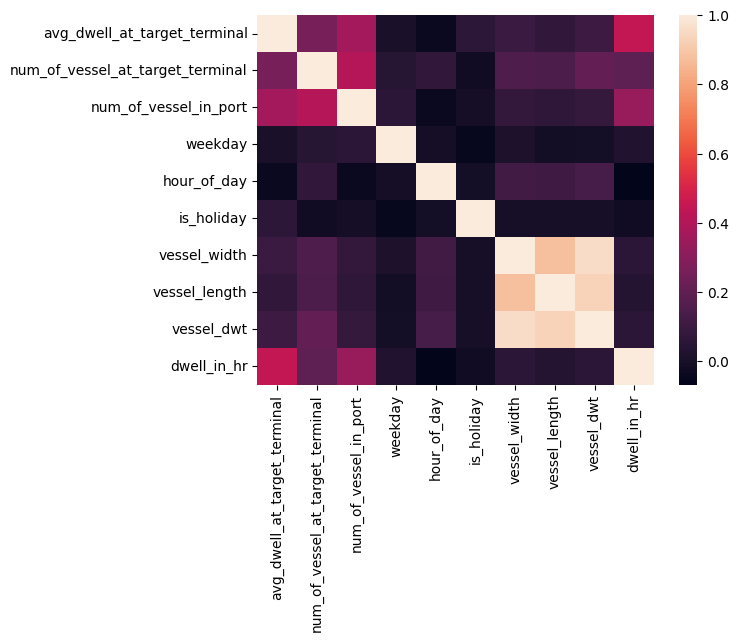

In [10]:
sns.heatmap(df.corr());

Take a quick peak at the distribution of **vessel_type** and **dwell_in_hr**. Due to many values outside of the quartiles on the top end of Container ships, we use log scale here.

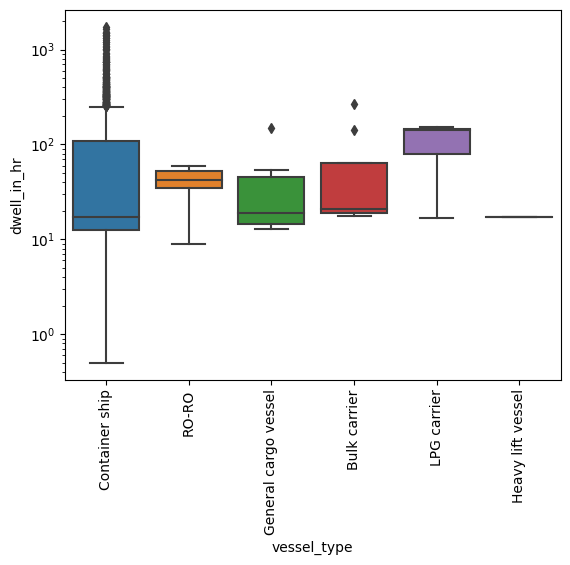

In [11]:
ax = sns.boxplot(y='dwell_in_hr',x='vessel_type',data=df)
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Look at the distribution of dwell time. Definitely very right skewed.

<AxesSubplot:>

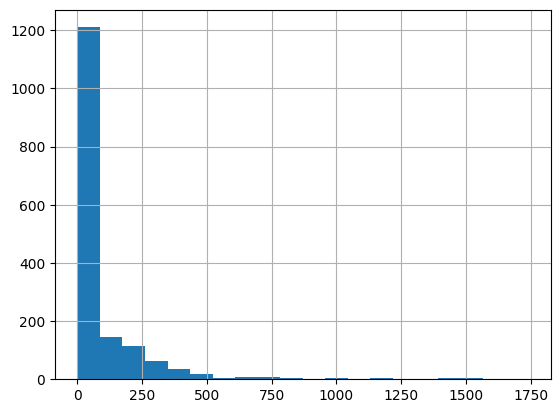

In [12]:
df.dwell_in_hr.hist(bins=20)

<AxesSubplot:>

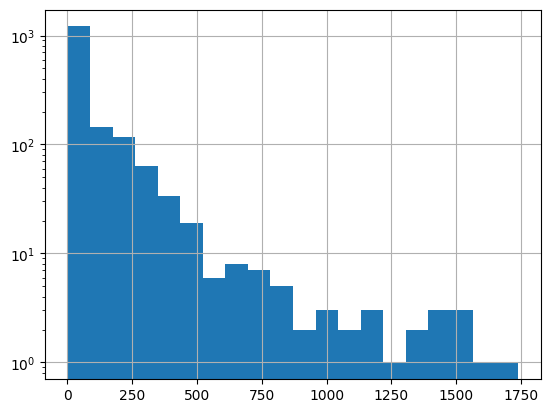

In [13]:
df.dwell_in_hr.hist(bins=20, log=True)

Get a quick idea of the ten most seen and ten least seen ships

In [14]:
from collections import Counter
counter = Counter(df.imo)
counter.most_common()[:10], counter.most_common()[-10:]

([('IMO9619684', 53),
  ('IMO7617905', 53),
  ('IMO7729459', 34),
  ('IMO7729461', 29),
  ('IMO9273674', 25),
  ('IMO9244130', 24),
  ('IMO7907996', 24),
  ('IMO7908005', 23),
  ('IMO9310238', 21),
  ('IMO9486087', 20)],
 [('IMO9806067', 1),
  ('IMO9415844', 1),
  ('IMO9457622', 1),
  ('IMO9606338', 1),
  ('IMO9311763', 1),
  ('IMO9400148', 1),
  ('IMO9516416', 1),
  ('IMO9456757', 1),
  ('IMO9308027', 1),
  ('IMO9401051', 1)])

The most seen ship, eyeball if there is anything special about it.

In [15]:
df[df['imo']=='IMO9273674']

,imo,vessel_name,time_seen,target_terminal,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_operator,vessel_type,vessel_width,vessel_length,vessel_dwt,dwell_in_hr
216,IMO9273674,MANULANI,2020-01-19 07:30:01,PierC,20.1,0.0,62.0,6,7,False,MATSON,Container ship,32.0,217.0,38261.0,10.1
217,IMO9273674,MANULANI,2020-02-23 12:34:24,PierC,10.1,0.0,32.0,6,12,False,MATSON,Container ship,32.0,217.0,38261.0,11.5
218,IMO9273674,MANULANI,2020-03-29 08:21:47,PierC,10.4,0.0,48.0,6,8,False,MATSON,Container ship,32.0,217.0,38261.0,9.7
219,IMO9273674,MANULANI,2020-05-03 02:55:39,PierC,11.3,0.0,51.0,6,2,False,MATSON,Container ship,32.0,217.0,38261.0,10.1
220,IMO9273674,MANULANI,2020-06-06 23:01:11,PierC,10.0,0.0,42.0,5,23,False,MATSON,Container ship,32.0,217.0,38261.0,14.0
221,IMO9273674,MANULANI,2020-07-11 21:26:16,PierC,13.2,0.0,44.0,5,21,False,MATSON,Container ship,32.0,217.0,38261.0,15.1
222,IMO9273674,MANULANI,2020-08-17 14:43:29,PierA,17.6,0.0,54.0,0,14,False,MATSON,Container ship,32.0,217.0,38261.0,10.8
223,IMO9273674,MANULANI,2020-09-20 08:00:01,PierC,10.6,0.0,43.0,6,8,False,MATSON,Container ship,32.0,217.0,38261.0,10.0
224,IMO9273674,MANULANI,2020-10-25 02:21:09,PierC,146.6,0.0,54.0,6,2,False,MATSON,Container ship,32.0,217.0,38261.0,10.2
225,IMO9273674,MANULANI,2020-11-29 04:51:59,PierC,117.0,0.0,69.0,6,4,False,MATSON,Container ship,32.0,217.0,38261.0,10.6


### Linear Regression with numeric features only

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imo                               1634 non-null   object 
 1   vessel_name                       1634 non-null   object 
 2   time_seen                         1634 non-null   object 
 3   target_terminal                   1634 non-null   object 
 4   avg_dwell_at_target_terminal      1634 non-null   float64
 5   num_of_vessel_at_target_terminal  1634 non-null   float64
 6   num_of_vessel_in_port             1634 non-null   float64
 7   weekday                           1634 non-null   int64  
 8   hour_of_day                       1634 non-null   int64  
 9   is_holiday                        1634 non-null   bool   
 10  vessel_operator                   1634 non-null   object 
 11  vessel_type                       1634 non-null   object 
 12  vessel

Numeric only features

In [17]:
features = ['avg_dwell_at_target_terminal', 'num_of_vessel_at_target_terminal',
            'num_of_vessel_in_port','weekday','hour_of_day','is_holiday',
            'vessel_width','vessel_length','vessel_dwt']
target = 'dwell_in_hr'

In [18]:
X = df[features].copy()
y = df[target]

X.shape, y.shape

((1634, 9), (1634,))

Set up X and y, and split into training and test sets

**Notes from class SIADS542 homework:** We must first perform feature normalization so that all features are on a standardized scale. We do this by applying the StandardScalar class from sklearn.preprocessing.

The details of how we do this are important. You must first split the data into training and test sets, and only after the split, do the feature normalization. This is to avoid giving information about the range of variables in the test split to the training split, which would be a form of **data leakage**.

In [19]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

X_train_raw.shape, X_train_raw.shape, y_train.shape, y_test.shape

((1225, 9), (1225, 9), (1225,), (409,))

In [20]:
X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

X_train.shape, X_test.shape

((1225, 9), (409, 9))

In [21]:
model = LinearRegression().fit(X_train, y_train)

model.intercept_

93.26457142857141

In [22]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
avg_dwell_at_target_terminal,69.366105
num_of_vessel_at_target_terminal,7.387882
num_of_vessel_in_port,25.322937
weekday,2.456606
hour_of_day,-9.283032
is_holiday,-8.160654
vessel_width,9.175015
vessel_length,8.848795
vessel_dwt,-14.384580


Get predictions

In [23]:
pred = model.predict(X_test)
pred[:25]

array([ 68.09499104, 173.6028974 ,  44.11154632,  18.89618414,
       136.67237692,  99.4251714 ,  38.53652501,  92.25143368,
       246.12627294,  35.09874476, -17.55400916,  88.22060258,
       146.00343212, 120.02105859, 110.04006028,  34.70783974,
       151.78643317,  63.12536055, 125.60424586, 116.78867391,
        19.86627188,  76.70501043,  22.5523136 , 189.69863972,
       102.65036099])

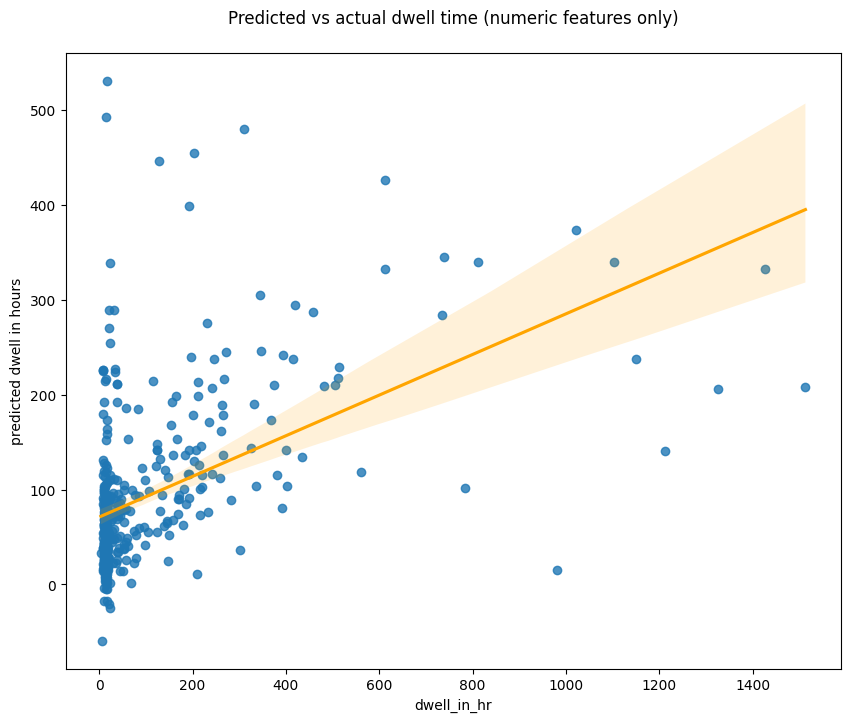

In [24]:
plt.subplots(figsize=(10,8))
sns.regplot(x=y_test,y=pred, line_kws={"color": "orange"})
plt.ylabel('predicted dwell in hours')
plt.title('Predicted vs actual dwell time (numeric features only)\n');

Score the model as a sanity check. This low score is in line with expectations and the chart above, since as mentioned earlier, there was low correlation found between the numeric variables and the dwell time was heavily skewed right.

In [25]:
model.score(X_test, y_test).round(2)

0.24

For this project we will use MAE as the measure of performance. As our report will mention, it's the same units as our target label and easy for end users to understand. We'll also print out some other measures as a sanity check. So far we see our MAE with this simple trial is 88.87.

In [26]:
df_err = pd.DataFrame(columns=['score','mse','rmse','mae','mape','med_ae','y_intercept'])

score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
med_ae = median_absolute_error(y_test, pred)

df_err.loc[0] = [score,mse,rmse,mae,mape,med_ae,model.intercept_]

df_err.round(2)

,score,mse,rmse,mae,mape,med_ae,y_intercept
0,0.24,32238.28,179.55,88.87,2.66,43.69,93.26


### Linear Regression with numeric and categoric features

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imo                               1634 non-null   object 
 1   vessel_name                       1634 non-null   object 
 2   time_seen                         1634 non-null   object 
 3   target_terminal                   1634 non-null   object 
 4   avg_dwell_at_target_terminal      1634 non-null   float64
 5   num_of_vessel_at_target_terminal  1634 non-null   float64
 6   num_of_vessel_in_port             1634 non-null   float64
 7   weekday                           1634 non-null   int64  
 8   hour_of_day                       1634 non-null   int64  
 9   is_holiday                        1634 non-null   bool   
 10  vessel_operator                   1634 non-null   object 
 11  vessel_type                       1634 non-null   object 
 12  vessel

This time we take numeric and categorical features, but we'll skip **imo**, **vessel_name**, **time_seen**, and **vessel_type** because we're only using to identify the record.

In [28]:
features = ['target_terminal', 'avg_dwell_at_target_terminal',
            'num_of_vessel_at_target_terminal', 'num_of_vessel_in_port',
            'weekday', 'hour_of_day', 'is_holiday',
            'vessel_operator','vessel_width', 'vessel_length', 'vessel_dwt']
target = 'dwell_in_hr'

In [29]:
X = df[features].copy()
y = df[target]

X.shape, y.shape

((1634, 11), (1634,))

Do one hot encoding to get the categorical features into a form that we can easily do regression.

In [30]:
X = pd.get_dummies(data=X)
X.shape

(1634, 51)

In [31]:
X.head()

,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_width,vessel_length,vessel_dwt,target_terminal_PierA,...,vessel_operator_SM LINE,vessel_operator_SNP SHIPPING SERVICES,vessel_operator_SUN ACE SHIPPING,vessel_operator_TA HO MARITIME,vessel_operator_TS LINE,vessel_operator_WAN HAI,vessel_operator_X-PRESS FEEDERS,vessel_operator_YANG MING,vessel_operator_ZHENHUA HEAVY INDUSTRY,vessel_operator_ZIM LINES
0,25.5,1.0,50.0,1,10,False,30.0,210.0,34677.0,0,...,0,0,0,0,0,0,0,0,0,0
1,46.4,2.0,53.0,6,10,False,30.0,210.0,34677.0,0,...,0,0,0,0,0,0,0,0,0,0
2,14.0,0.0,57.0,2,0,False,32.0,262.0,30825.0,1,...,0,0,0,0,0,0,0,0,0,0
3,11.5,0.0,49.0,6,2,False,32.0,262.0,30825.0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.7,0.0,57.0,6,11,False,32.0,262.0,30825.0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll set up our training and test data with these new columns included.

**Notes from class SIADS542 homework:** We must first perform feature normalization so that all features are on a standardized scale. We do this by applying the StandardScalar class from sklearn.preprocessing.

The details of how we do this are important. You must first split the data into training and test sets, and only after the split, do the feature normalization. This is to avoid giving information about the range of variables in the test split to the training split, which would be a form of data leakage.

In [32]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

X_train_raw.shape, X_train_raw.shape, y_train.shape, y_test.shape

((1225, 51), (1225, 51), (1225,), (409,))

In [33]:
X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

X_train.shape, X_test.shape

((1225, 51), (409, 51))

Fit the model

In [34]:
model = LinearRegression().fit(X_train, y_train)

model.intercept_

93.2694823108841

Get predictions

In [35]:
pred = model.predict(X_test)
pred[:25]

array([-1.98589312e+13, -1.32823888e+13, -1.98589312e+13, -1.01182835e+13,
       -1.01182835e+13,  5.43561908e+12,  9.18439955e+12, -2.03705873e+13,
       -1.09162266e+14, -1.92560969e+13, -1.92560969e+13,  5.43561908e+12,
        1.28601609e+13, -6.23416155e+12, -1.92560969e+13,  9.18439955e+12,
        3.18647538e+13, -1.12542061e+13,  2.22152844e+13, -1.01182835e+13,
       -2.03705873e+13,  5.43561908e+12, -1.92560969e+13, -1.32823888e+13,
       -1.01182835e+13])

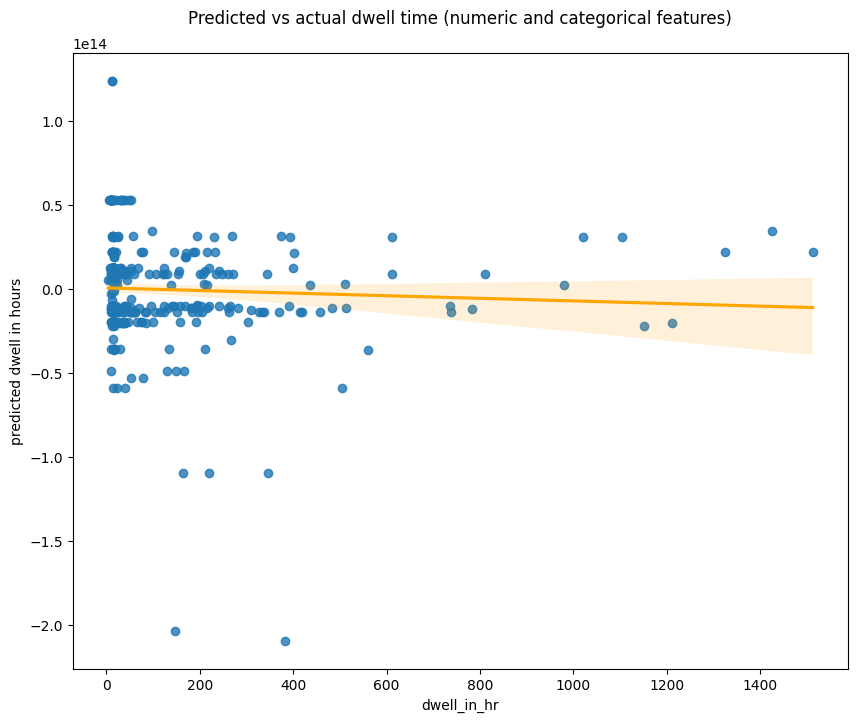

In [36]:
plt.subplots(figsize=(10,8))
sns.regplot(x=y_test,y=pred, line_kws={"color": "orange"})
plt.ylabel('predicted dwell in hours')
plt.title('Predicted vs actual dwell time (numeric and categorical features)\n');

In [37]:
model.score(X_test, y_test).round(2)

-2.05942882576249e+22

Mean Absolute Error (MAE) for our model above

In [38]:
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
print('score: {:.3f}\nmse: {:.3f}\nrmse: {:.3f}\nmae: {:.3f}\nmape: {:.3f}\ny_inter: {:.3f}'.format(score,mse,rmse,mae,mape,model.intercept_))

score: -20594288257624900108288.000
mse: 875231917754793121156169728.000
rmse: 29584318781320.504
mae: 20253018819580.734
mape: 974267802023.304
y_inter: 93.269


### Cross-validation

Now that we have our data with numeric and categorical features, we'll run it through a more rigorous training method of cross validation.

First a sanity check with cross-validation to get model accuracy score (r^2). From SIADS542 we learned "The r-squared score, despite the squared in the name that suggests is not always positive, does have the potential to go negative for bad model fits, such as when fitting nonlinear functions to data." So we're getting a negative score of -1.20. It's consistent with our visual earlier, that a basic linear regression model is a bad fit. Again we're just using this as a baseline.

In [39]:
kfold = 10
cv_result = cross_val_score(LinearRegression(), X, y, cv=kfold, scoring="r2")
print('cv_result score', cv_result)
print('\ncv_result score, mean: {:.3f}'.format(cv_result.mean()))

cv_result score [ -3.12642854  -0.81496655  -0.44731981   0.23376507  -0.17016891
   0.41419378   0.30172781   0.04607539 -10.52979419  -5.33929896]

cv_result score, mean: -1.943


Cross validate using K-fold to get the MAE. This is the official performance measure we'll use in our report.



In [40]:
kfold = 10
cv_result = cross_val_score(LinearRegression(), X, y, cv=kfold, scoring="neg_mean_absolute_error")
print('cv_result MAE', cv_result)
print('\ncv_result mean of MAE\'s {:.3f} ± {:.3f}'.format(abs(cv_result.mean()),cv_result.std()))


cv_result MAE [ -55.75811365  -50.31894132  -66.45339246  -82.17757631  -82.92117448
 -103.49182794 -125.78601606 -203.06761859  -75.52125726  -87.92168868]

cv_result mean of MAE's 93.342 ± 42.145


Just for fun, we'll cross validate using K-fold to get the Median Absolute Error since our visuals showed some outliers. SIADS542 "you can use the median_absolute_error score, which is robust with the presence of outliers because it uses the median of the error distribution rather than the mean."

In [41]:
kfold = 10
cv_result = cross_val_score(LinearRegression(), X, y, cv=kfold, scoring="neg_median_absolute_error")
print('cv_result Median AE', cv_result)
print('\ncv_result mean of Median AE\'s {:.3f} ± {:.3f}'.format(cv_result.mean(),cv_result.std()))


cv_result Median AE [ -47.67548527  -43.23242642  -42.893538    -68.18264864  -51.07733756
  -73.41521201  -72.80264653 -105.77392213  -32.48687022  -65.35760313]

cv_result mean of Median AE's -60.290 ± 20.239


### Key Findings

* Our basic EDA of the data shows that the variables are not strongly correlated. This is not a great sign that Linear Regression will work. But we're really using this as a base line.
* Linear Regression had a tough time predicting values, whether with numerical only, or with both numerical and categorical data.
* Our best 10 kfold Cross Validated testing showed **93.342 ± 42.145**
* Next we'll look at RandomForestRegressor.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>